# Introduction 

Following Code Uses PyLag, offline Particle Tracking model and FVCOM outputs that are Downloaded from the following for 2023 https://noaa-nos-ofs-pds.s3.amazonaws.com/index.html#lmhofs/netcdf
and Computes Lagrangian Particle Tracking for particles that are release at the mouth of Lake Huron's stream watersheds.

in the local directory they are placed here
FVCOME files are in this location 
#S:\Data\External_Models\Outputs\GLCFS\LakeHuron

## Required imports

In [3]:
# File system and configuration management
import os
import configparser

# Data handling and processing
import numpy as np
import pandas as pd
from collections import namedtuple
from datetime import timedelta, datetime

# NetCDF data handling
from netCDF4 import Dataset
from cftime import num2pydate
import xarray as xr
# Visualization: general plotting, Cartopy, and Matplotlib utilities
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs

# FVCOM-specific visualization and utility tools
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap
from pylag.processing.utils import get_grid_bands
from pylag.grid_metrics import create_fvcom_grid_metrics_file

# Regridding, viewing, and garbage collection utilities
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
import gc


# Inputs

In [4]:
FVCOM_DIR='/home/abolmaal/Data/FVCOMEDATA'.format(os.environ['HOME']) 

# Create run directory
cwd = os.getcwd()
# Create run directory
MODELLING_DIR = '/home/abolmaal/modelling/FVCOM/Huron'.format(cwd)
try:
    os.makedirs(MODELLING_DIR)
except FileExistsError:
    pass


# Create input sub-directory for input files
input_dir = '{}/input'.format(MODELLING_DIR)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass


# input file to create grid metrics
fvcom_file_name = os.path.join(FVCOM_DIR, '202306','nos.lmhofs.fields.n000.20230601.t00z.nc')

# The file listing the location of open boundary nodes

obc_file_name = os.path.join(MODELLING_DIR,'input', 'obc.dat')



# initial position of the particles
initial_position_file = os.path.join(FVCOM_DIR, 'input', 'initial_positions_releasezone_intersection_multigroup.dat')


# config file
config_file_name = os.path.join(MODELLING_DIR, 'config_files', 'Huron_Senseflux_Seasonal.cfg')


# Outputs

In [5]:
# The name of the output file containing the grid metrics
# create a sub directory for the grid file
grid_file_dir = f'{input_dir}/gridfile'
try:
    os.makedirs(grid_file_dir)
except FileExistsError:
    pass
grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'

#grid_metrics_file_name = f'{input_dir}/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'



# Create output sub-directory
output_dir = '{}/output'.format(MODELLING_DIR)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Create Figure sub-directory
fig_dir = '{}/figures'.format(MODELLING_DIR)

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)


# output path saving the figure
fig_path_initilapositions = os.path.join(fig_dir, 'initial_positions_LakeHuron_multigrouppoint_intersection.jpeg')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface

# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'


# Parameters

## Figure Parameters

In [7]:
#Figure Parameters
# Create figure
font_size = 15
figsize=(26., 26.)
cmap = colourmap('h_r')
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)


# Bathymetry 

# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
# make a color scale of light green to blue 
GnBu = LinearSegmentedColormap.from_list('GnBu', [(0, '#f0f9e8'), (0.5, '#bae4bc'), (1, '#7bccc4')], N=256)
bathy_cmap = GnBu

ds.close()
del(ds)

# extends 
#Lake Huron extents
extents_LH = np.array([275, 277.69, 43, 46.3], dtype=float)
extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)
#
batch_size = 50


# Main Functions

## 1-Create Grid metrics

#### this part is only need to run one time

In [7]:
# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name = obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc
INFO - detected longitudes greater than 180.0 in variable lon. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.
INFO - detected longitudes greater than 180.0 in variable lonc. Assuming longitude limits are in the range 0 - 360. Correcting these to be in the range -180 to 180.

Calculating element areas ... done
Grid has 51110 nodes on the open boundary


## 2-Creating Run configuration

In [23]:
cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with FVCOM in cartesian coordinates0
print('Model name: {}'.format(cf.get('OCEAN_DATA', 'name')))
print('Coordinate system: {}'.format(cf.get('SIMULATION', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_DATA', 'FVCOM_DIR')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_DATA', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_DATA', 'data_file_stem')))
      
# Do an advection only run using a RK$ intergration scheme 
print('Numerical method: {}'.format(cf.get('NUMERICS', 'num_method')))
print('Iterative method: {}'.format(cf.get('NUMERICS', 'iterative_method')))

Start time: 2022-11-01  00:00:00
End time: 2023-04-30  23:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: FVCOM
Coordinate system: geographic
Data directory: /home/abolmaal/Data/FVCOMEDATA
Path to grid metrics file: /home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc
File name stem of input files: nos.lmhofs.fields.n000.
Numerical method: standard
Iterative method: Adv_RK4_3D


# I am not using part 3-5

## 3-Setting Mortality

If you use the following config file huron_senseflux_20230103_Seasonal_mortality.cfg, you don't need to run section 5. it is here for demonstration and showing how mortality works.

In [42]:
# # Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from configparser import ConfigParser

import pylag.random as random
from pylag.data_reader import DataReader
from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.mortality import get_mortality_calculator
from pylag.processing.plot import create_figure

# Ensure inline plotting
%matplotlib inline

# Parameters
seconds_per_day = 86400.

# Seed the random number generator
random.seed(10)

# Create the config
#cf.add_section('NUMERICS')
cf.add_section('BIO_MODEL')
cf.add_section('FIXED_TIME_MORTALITY_CALCULATOR')
cf.add_section('PROBABILISTIC_MORTALITY_CALCULATOR')
# We need a data reader to pass to the mortality calculator. It
# can be used to draw out environmental variables (e.g. temperature)
# that affect mortality. In both cases below, it isn't used, so we
# use the base class.
data_reader = DataReader()

# Set time stepping params
n_particles = 1000
simulation_duration_in_days = 30.0
time_step = 100
time_end = simulation_duration_in_days * seconds_per_day
times = np.arange(0.0, time_end, time_step)

In [ ]:
#  #Helper function in which the model is run and mortality computed
# def run(config, n_particles=1000):
#     """ Run the model to compute mortality through time """

#     # Create the mortality calculator
#     mortality_calculator = get_mortality_calculator(config)

#     # Create the living particle seed
#     particle_set = []
#     for i in range(n_particles):
#         # Instantiate a new particle
#         particle = ParticleSmartPtr(age=0.0, is_alive=True)

#         # Initialise particle mortality parameters
#         mortality_calculator.set_initial_particle_properties_wrapper(particle)

#         # Append it to the particle set
#         particle_set.append(particle)

#     # Store the number of living particles in a list
#     n_alive_arr = []

#     # Run the model
#     n_alive = n_particles
#     for t in times:
#         n_alive_arr.append(n_alive)

#         n_deaths = 0
#         for particle in particle_set:
#             if particle.is_alive:
#                 mortality_calculator.apply_wrapper(data_reader, t, particle)
#                 if particle.is_alive == False:
#                     n_deaths += 1
#             particle.set_age(t)

#         n_alive -= n_deaths

#     return n_alive_arr

## 4-FixedTimeMortalityCalculater

In [ ]:
# # Specify a fixed time mortality calculator
# cf.set('BIO_MODEL', 'mortality_calculator', 'fixed_time')

# # 1) Fixed time scenario
# # Sharp_2021 suggerst 10 days fpr N uptake in coastal wetlands
# age_of_death_in_days = 10.
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'common_value')
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'common_value', str(age_of_death_in_days))
# n_alive_common_value = run(cf)

In [ ]:
# # 2) Uniform Random 
# minimum_bound = 8.
# maximum_bound = 12.
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'uniform_random')
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'minimum_bound', str(minimum_bound))
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'maximum_bound', str(maximum_bound))
# n_alive_uniform_random = run(cf)

In [ ]:
# # 2) Gaussian random
# mean = 10.
# standard_deviation = 1.
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'initialisation_method', 'gaussian_random')
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'mean', str(mean))
# cf.set('FIXED_TIME_MORTALITY_CALCULATOR', 'standard_deviation', str(standard_deviation))
# n_alive_gaussian_random = run(cf)
# # Set the bio time step
# cf.set('NUMERICS', 'time_step_bio', str(time_step))

In [ ]:
# Plot
# font_size = 10
# fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
# plt.plot(times/seconds_per_day, n_alive_common_value, 'b', label='common_value')
# plt.plot(times/seconds_per_day, n_alive_uniform_random, 'r', label='uniform_random')
# plt.plot(times/seconds_per_day, n_alive_gaussian_random, 'g', label='gaussian_random')
# # Set the bio time step
# plt.ylabel('Living individuals (-)', fontsize=font_size)
# plt.xlabel('Time (d)', fontsize=font_size)

# # Add legend
# plt.legend()

## 5-ProabilisticMortalityCalculator

The mortality calculator kills particles at a rate 
, where 
 is a fixed mortality rate which is set in the run configuraiton file and 
 is the model time step for biological processes. The model computes a uniform random deviate in the range (0, 1). If the number is less than the computed death rate, the particle is killed. Below, we create a population of 
 individuals. We apply a death rate of 
 per day and use a time step of 
 seconds. The model is run forward for 
 days and the number of living individuals plotted as a function of time. The result is compared with a simple analytical solution of exponential decay

In [ ]:

# # Specify a probabilistic mortality calculator
# cf.set('BIO_MODEL', 'mortality_calculator', 'probabilistic')

# # Set the death rate - currently the same for all particles.
# death_rate_per_day = 0.1
# cf.set('PROBABILISTIC_MORTALITY_CALCULATOR', 'death_rate_per_day', str(death_rate_per_day))

# # Set the bio time step
# cf.set('NUMERICS', 'bio_time_step', str(time_step))

# # Number of particles
# n_particles = 1000

# # Run the model
# n_alive_numeric = run(cf, n_particles=n_particles)

# # Compute the equivalent analytical solution
# death_rate_per_second = death_rate_per_day / seconds_per_day
# n_alive_analytic = n_particles * np.exp(-death_rate_per_second * times)

# # Plot
# font_size = 10
# fig, ax = create_figure(figure_size=(20, 20), font_size=font_size)
# plt.plot(times/seconds_per_day, n_alive_numeric, 'b', label='numeric')
# plt.ylabel('Living individuals (-)', fontsize=font_size)
# plt.xlabel('Time (d)', fontsize=font_size)

# # Add equivalent analytical solution
# plt.plot(times/seconds_per_day, n_alive_analytic, 'r', label='analytic')

# # Add legend
# plt.legend()

# 6-Run the model 

In [24]:
cf.set('OCEAN_DATA', 'data_dir', FVCOM_DIR)
cf.set('OCEAN_DATA', 'grid_metrics_file', grid_metrics_file_name)
# Directory where the simulation outputs will be saved
out_dir = f"{MODELLING_DIR}/output"
cf.set('GENERAL', 'out_dir', out_dir)

# Save a copy in the simulation directory
with open(f"{MODELLING_DIR}/pylag.cfg", 'w') as config:
    cf.write(config)

In [25]:
# Change to the run directory
os.chdir(f"{MODELLING_DIR}")

# Run the model
!{"python -m pylag.main -c pylag.cfg"}

# Return to the cwd
os.chdir(cwd)


Starting ensemble member 1 ...
Progress:
100% |###########################################|


# 7-Plotting the Data

### Plot Initial Positions

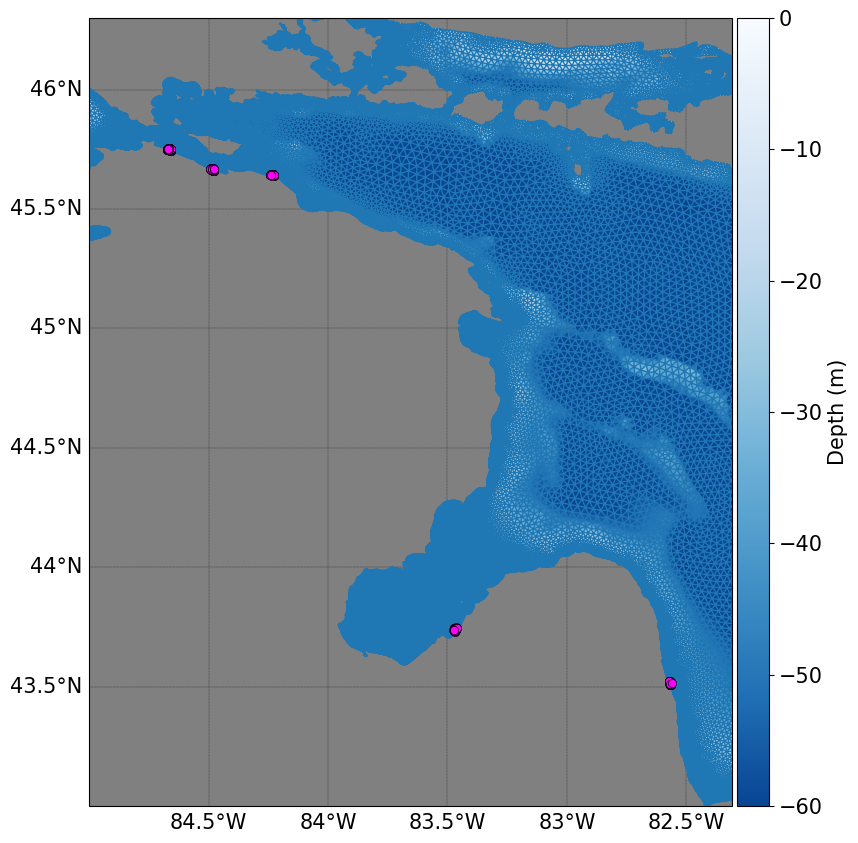

In [ ]:
# Read the initial position file into a pandas DataFrame and skip the first line
df = pd.read_csv(f"{MODELLING_DIR}/input/initial_position/initial_positions_releasezone_intersection_multigroup.dat", sep = ' ',skiprows=1)
group_id = df.iloc[:,0]
lons = df.iloc[:,1] 
lats= df.iloc[:,2]

# Create figure

fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(),
                      font_size=font_size, bg_color='gray')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
ax, plot = plotter.plot_field(ax, bathy, extents=extents_LH, add_colour_bar=True, cb_label='Depth (m)',
                              vmin=-60., vmax=0., cmap=blue_cmap_reversed)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Plot particle initial positions
scatter = plotter.scatter(ax, lons, lats, s=35, color='fuchsia', edgecolors='black', linewidth=0.5, zorder=10)

# save the initial positions figure in the figure directory

plt.savefig(fig_path_initilapositions, dpi=300)

### Plotting PyLag results

In [12]:
output_dir = '/home/abolmaal/modelling/FVCOM/Huron/output/MaytoOct'

In [13]:
# Create a list of file names
import re
import os
from datetime import timedelta
import gc
import matplotlib.pyplot as plt

# Custom sorting function to extract numerical part after "__"
def extract_sort_key(filename):
    match = re.search(r'__(\d+)\.nc$', filename)
    if match:
        return int(match.group(1))  # Extract the numeric identifier after "__"
    return float('inf')  # If no match, push the file to the end

# Process files
for file_name in sorted(filter(lambda x: x.endswith(".nc"), os.listdir(output_dir)), key=extract_sort_key):
    sample_name = file_name
    file_name = os.path.join(output_dir, file_name)
    time_of_flight = timedelta(hours=6)
   
    # Set the extents
    extents = extents_LH
    
    # Create figure
    fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')
    
    # Assuming grid_metrics_file_name, bathy, and cmap are defined elsewhere
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    plotter.plot_field(ax, bathy, extents=extents_LH, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=cmap)
    
    viewer = Viewer(file_name, time_rounding=21600)
    date = viewer.date[0] + time_of_flight
    if date in viewer.date.tolist():
        time_index = viewer.date.tolist().index(date)
    else:
        print(f"Date {date} not found in viewer.date")
        continue
    # Convert positions into lons/lats
    lons, lats = [viewer('longitude')[time_index, :].squeeze(), viewer('latitude')[time_index, :].squeeze()]
    
    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=20, color='#e50000', edgecolors='black')
    
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, :], viewer('latitude')[:time_index + 1, :])
    
    # Convert all pathline coordinates into lons/lats
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.5, alpha=1, color='#0504aa')
    
    output_file = os.path.join(fig_dir, f"{sample_name.split('.')[0]}.png")
    plt.savefig(output_file, dpi=50)
    plt.close(fig)
    gc.collect()


In [14]:
output_file

'/home/abolmaal/modelling/FVCOM/Huron/figures/Fvcom_Huron_23_MaytoOct_1.png'

In [12]:
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/output/Yearly'

In [44]:
fig_dir = '/home/abolmaal/modelling/FVCOM/Huron/figures/Winter'

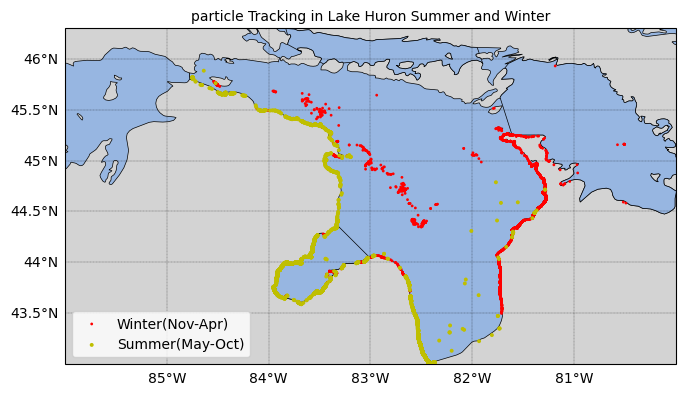

In [15]:
import numpy as np
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, ArakawaAPlotter


%matplotlib inline


# Plot options
font_size = 10

# Create figure
fig, ax = create_figure(figure_size=(20., 20.), projection=ccrs.PlateCarree(),
                        font_size=font_size, bg_color='white')

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                          font_size=font_size)

extents = [274,280, 43,46.3]
#extent=[276.5,276.8,44.8,45.5]
#extents=[276.5, 276, 43.58, 44]
# Add tracks from the ocean only run
# ----------------------------------
# PyLag file name
file_name = f'{out_dir}/Fvcom_Huron_23_NovtoApr_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=4, color='r', edgecolors='none',
                configure=True,
                draw_coastlines=True,
                tick_inc=True,
                extents=extents,label= 'Winter(Nov-Apr)')

# Add high resolution land
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5)

# Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=0.005, alpha=1, color='black')


# Add tracks from the ocean + stokes drift run
# --------------------------------------------
# PyLag file name
file_name = f'{out_dir}/Fvcom_Huron_23_MaytoOct_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='y', edgecolors='none', label = 'Summer(May-Oct)')

# # Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='y')


# # Add tracks from the ocean + leeway run
# # --------------------------------------
# # PyLag file name
# file_name = f'{out_dir}/Fvcom_Huron_23_Oct__10.nc'

# # Dataset holding particle positions
# viewer = Viewer(file_name, time_rounding=60)

# # Plot final positions
# plotter.scatter(ax,
#                 viewer('longitude')[-1, :].squeeze(),
#                 viewer('latitude')[-1, :].squeeze(),
#                 s=8, color='b', edgecolors='none', label = 'OCt')
plt.legend()
plt.title('particle Tracking in Lake Huron Summer and Winter', fontsize=font_size)

# Save the figure
output_file = os.path.join(fig_dir, 'tracks_LakeHuron_Summerwinter.jpeg')
plt.savefig(output_file, dpi=300)

# Plot paths
# _ = plotter.plot_lines(ax,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=1., alpha=1, color='b')

/tmp/ipykernel_11323/623873984.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


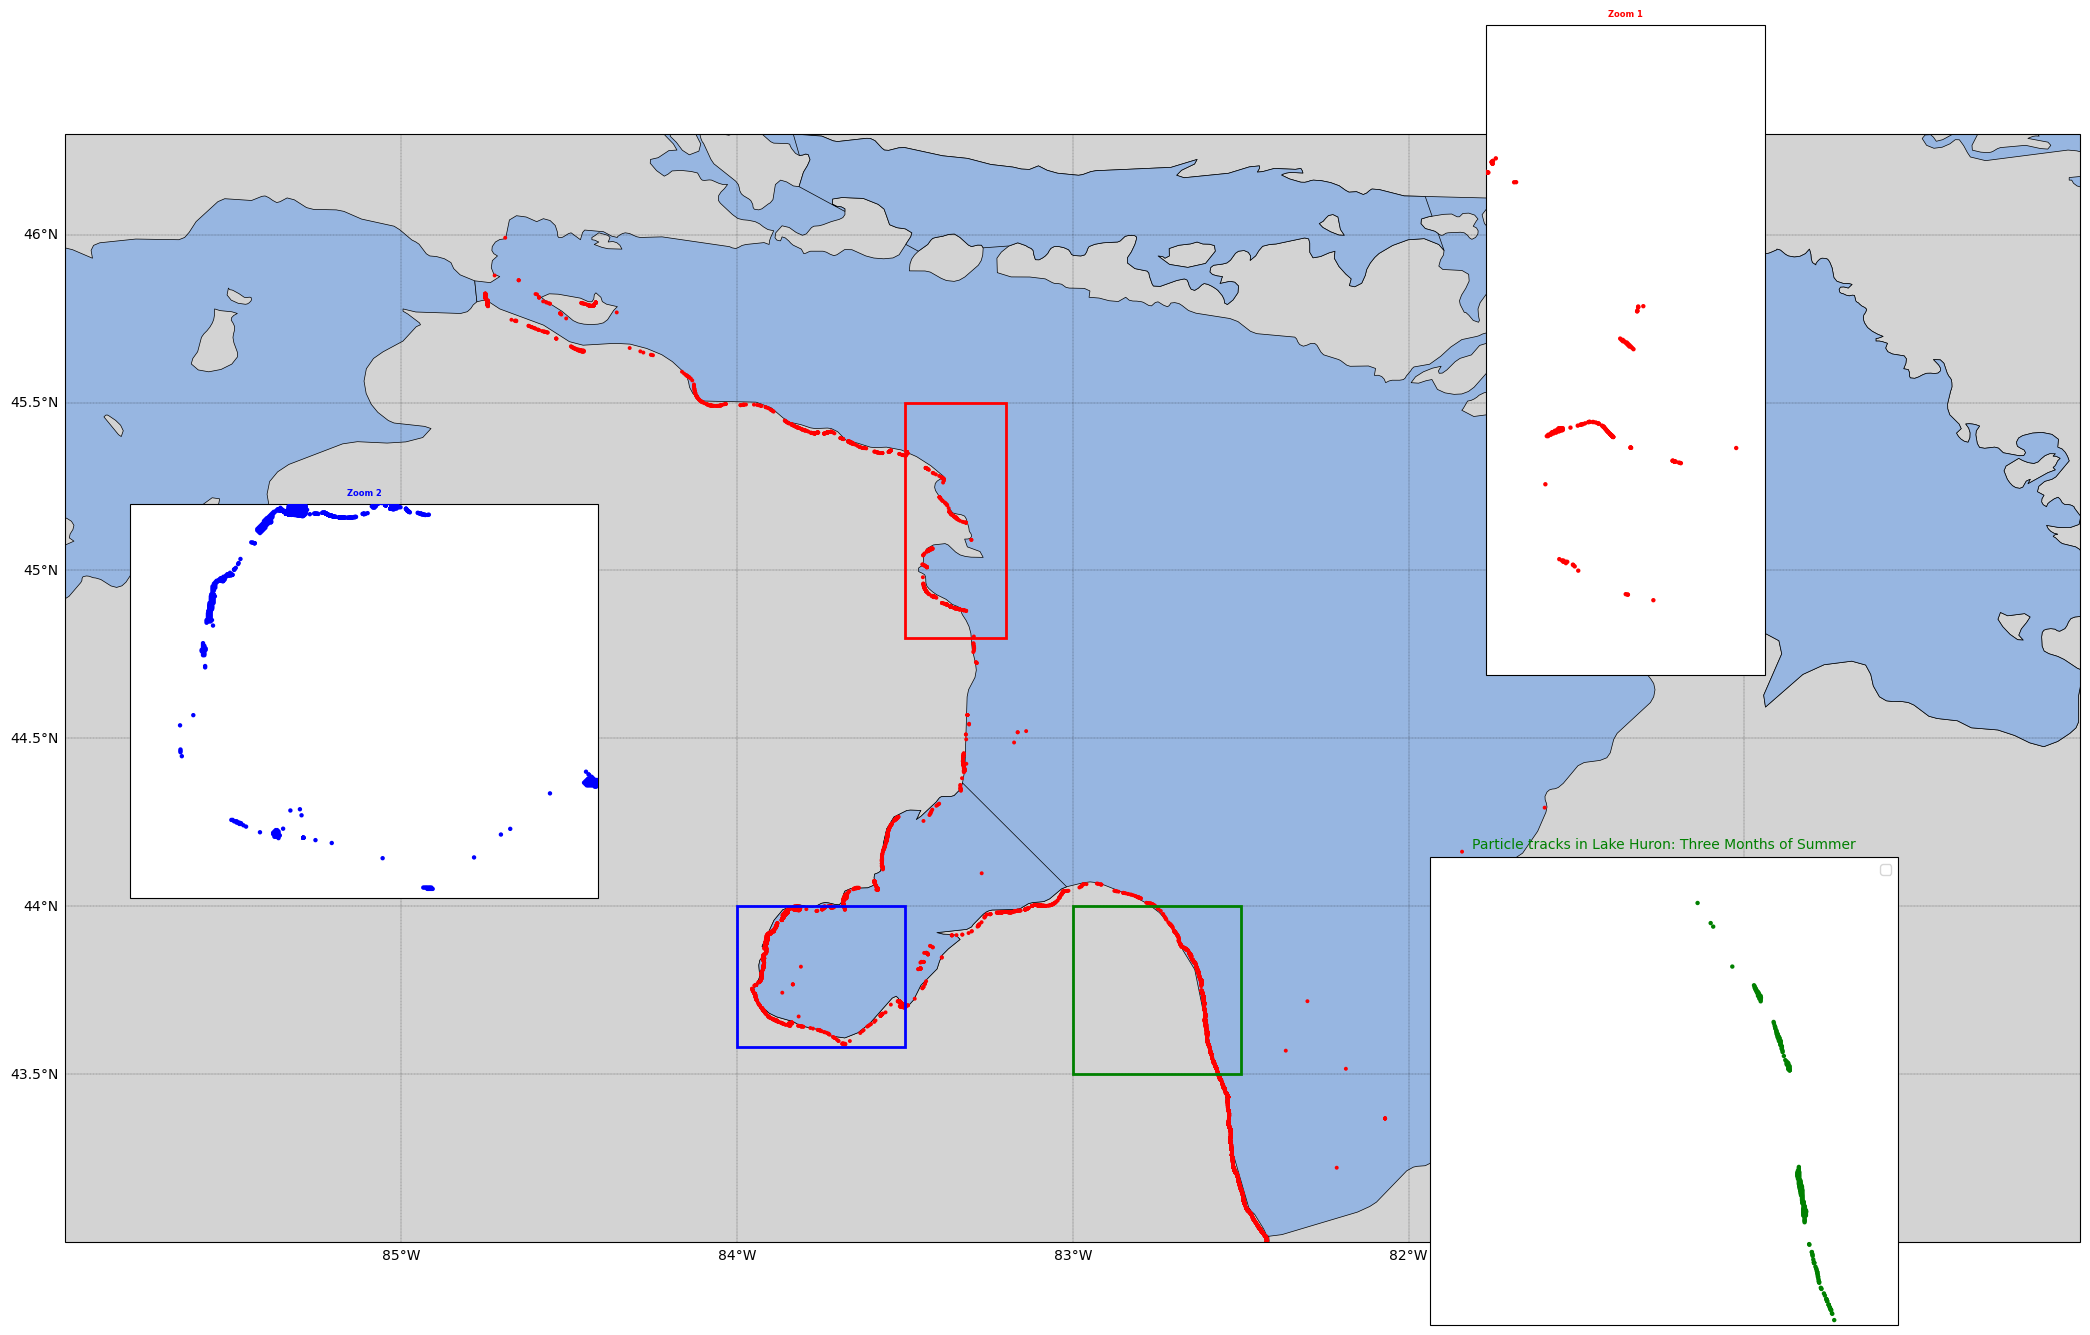

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

from pylag.processing.ncview import Viewer
from pylag.processing.plot import create_figure, FVCOMPlotter

# ✅ Define plot options
font_size = 10

# ✅ Define main and zoomed-in extents
main_extents = [274, 280, 43, 46.3]  # Main map extent
zoom_extents_1 = [276.5, 276.8, 44.8, 45.5]  # Zoom-in 1
zoom_extents_2 = [276.5, 276, 43.58, 44]  # Zoom-in 2
zoom_extents_3 = [277.5, 277, 43.5, 44]  # Zoom-in 3

# ✅ Create figure with main map
fig = plt.figure(figsize=(26, 26))
ax_main = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_main.set_extent(main_extents, crs=ccrs.PlateCarree())

# ✅ Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, font_size=font_size)

# ✅ PyLag file name
file_name = f'{out_dir}/Fvcom_Huron_23_JunJulAug_1.nc'

# ✅ Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# ✅ Plot final positions (red for summer)
plotter.scatter(ax_main,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='r', edgecolors='none',
                configure=True,
                draw_coastlines=True,
                tick_inc=True,
                extents=main_extents,
                label='JunJulAug')

# ✅ Add high-resolution land features
ax_main.add_feature(cfeature.LAND, facecolor='lightgrey')
ax_main.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_main.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax_main.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5)

# ✅ Plot paths (particle tracks)
# _ = plotter.plot_lines(ax_main,
#                        viewer('longitude')[:, :].squeeze(),
#                        viewer('latitude')[:, :].squeeze(),
#                        linewidth=0.005, alpha=1, color='black')

file_name = f'{out_dir}/Fvcom_Huron_23_OctNovDec_1.nc'

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=60)

# Plot final positions
plotter.scatter(ax,
                viewer('longitude')[-1, :].squeeze(),
                viewer('latitude')[-1, :].squeeze(),
                s=8, color='y', edgecolors='none', label = 'Nov')

# ✅ Define inset positions relative to the figure (x, y, width, height)
inset_positions = [
    [0.60, 0.50, 0.25, 0.25],  # Top right
    [0.15, 0.40, 0.18, 0.18],  # Top left
    [0.65, 0.25,0.18, 0.18]   # Bottom center
]

# ✅ Define zoom extents
zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
colors = ['red', 'blue', 'green']

# ✅ Loop through the three insets
for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
    # ✅ Create inset axes manually
    left, bottom, width, height = inset_pos
    ax_inset = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
    ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())

    # ✅ Plot zoomed-in scatter points
    plotter.scatter(ax_inset,
                    viewer('longitude')[-1, :].squeeze(),
                    viewer('latitude')[-1, :].squeeze(),
                    s=10, color=color, edgecolors='none')

    # ✅ Plot paths inside zoomed-in inset
    # _ = plotter.plot_lines(ax_inset,
    #                        viewer('longitude')[:, :].squeeze(),
    #                        viewer('latitude')[:, :].squeeze(),
    #                        linewidth=0.05, alpha=1, color=color)

    # ✅ Set zoomed-in title
    ax_inset.set_title(f"Zoom {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

    # ✅ Remove axis ticks for zoom-in maps
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])

    # ✅ Add rectangle to highlight zoomed-in region on main map
    rect = plt.Rectangle(
        (zoom_extent[0], zoom_extent[2]),
        zoom_extent[1] - zoom_extent[0],
        zoom_extent[3] - zoom_extent[2],
        linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
    )
    ax_main.add_patch(rect)  # ✅ Ensure the rectangle is added to the main map

# ✅ Add legend
plt.legend()
plt.title('Particle tracks in Lake Huron: Three Months of Summer', fontsize=font_size)

# ✅ Save the figure
output_file = os.path.join(fig_dir, 'tracks_LakeHuron_JunJulyAug.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# ✅ Show the plot
plt.show()


In [22]:
out_dir ='/home/abolmaal/modelling/FVCOM/Huron/output/Winter'

Variable 'group_number' not found in /home/abolmaal/modelling/FVCOM/Huron/output/Winter/Fvcom_Huron_23_OctNovDec_1.nc


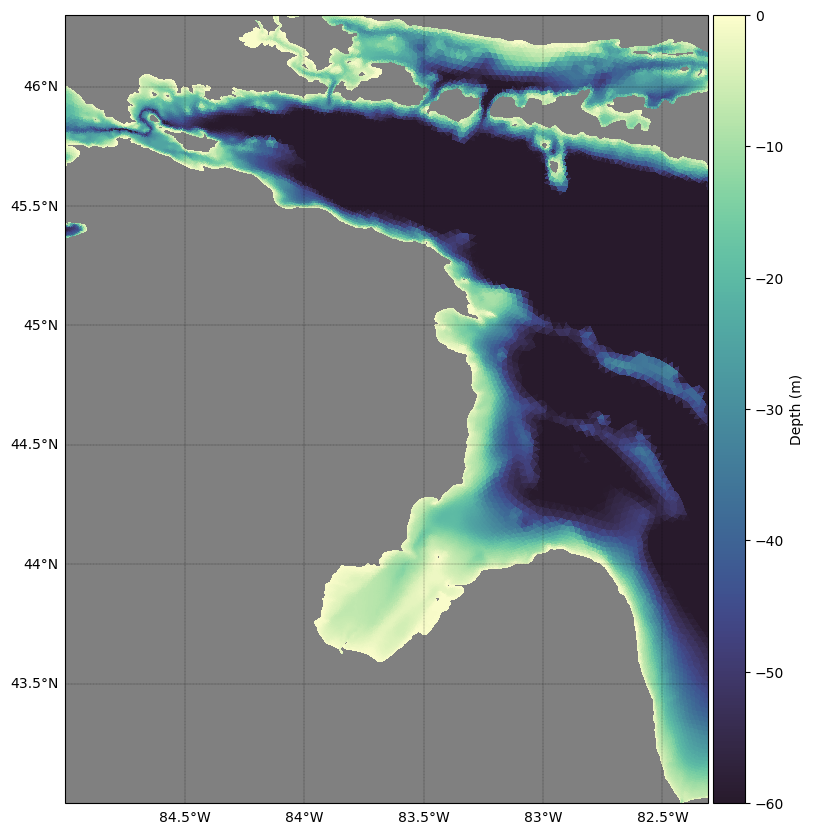

In [23]:
import re
import os
from datetime import timedelta
import gc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Define the function to sort the files based on the time
def extract_sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('__')[1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Specify `group_id` and `group_number` for filtering
target_group_id = 57  # Change to your specific group_id
target_group_number = '57040'  # Change to your specific group_number

for file_name in sorted(filter(lambda x: x.endswith(".nc"), os.listdir(out_dir)), key=extract_sort_key):
    sample_name = file_name
    file_name = os.path.join(out_dir, file_name)
    time_of_flight = timedelta(hours=24)
   
    # Create figure
    fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    plotter.plot_field(ax, bathy, extents=extents_LH, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=cmap)
    
    viewer = Viewer(file_name, time_rounding=25200)
    date = viewer.date[0] + time_of_flight
    if date in viewer.date.tolist():
        time_index = viewer.date.tolist().index(date)
    else:
        print(f"Date {date} not found in viewer.date")
        continue
    
    # Sanity checks for `group_id` and `group_number`
    try:
        group_ids = viewer('group_id')[:].squeeze()  # Assuming 'group_id' is a variable in the file
        group_numbers = viewer('group_number')[:].squeeze()  # Assuming 'group_number' is a variable in the file
    except KeyError as e:
        print(f"Variable {str(e)} not found in {file_name}")
        continue
    
    # Filter particles by `group_id` and `group_number`
    target_indices = (group_ids == target_group_id) & (group_numbers == target_group_number)
    
    if not target_indices.any():
        print(f"No particles found for group_id={target_group_id} and group_number={target_group_number}")
        continue
    
    # Extract positions for the specific group_id and group_number
    lons, lats = [viewer('longitude')[time_index, target_indices].squeeze(),
                  viewer('latitude')[time_index, target_indices].squeeze()]
    
    # Plot particle final positions
    ax, scatter = plotter.scatter(ax, lons, lats, s=200, color='#e50000', edgecolors='black')
    
    # Extract pathlines for the specific group_id and group_number
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, target_indices],
                              viewer('latitude')[:time_index + 1, target_indices])
    
    # Plot the particle pathlines
    ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.5, alpha=1, color='#0504aa')
    
    # Save the figure
    output_file = os.path.join(fig_dir, f"{sample_name.split('.')[0]}_particle_{target_group_id}_{target_group_number}.png")
    plt.savefig(output_file, dpi=50)
    plt.close(fig)
    gc.collect()



In [ ]:
# Define the function to sort the files based on the time
def extract_sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('__')[1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Specify `group_id` and `group_number` for filtering
target_group_id = 2  # Change to your specific group_id
target_group_number = '57040'  # Change to your specific group_number

for file_name in sorted(filter(lambda x: x.endswith(".nc"), os.listdir(out_dir)), key=extract_sort_key):
    try:
        sample_name = file_name
        file_name = os.path.join(out_dir, file_name)
        time_of_flight = timedelta(hours=24)

        # Create figure
        fig, ax = create_figure(figure_size=figsize, projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')
        plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

        viewer = Viewer(file_name, time_rounding=25200)
        date = viewer.date[0] + time_of_flight
        if date in viewer.date.tolist():
            time_index = viewer.date.tolist().index(date)
        else:
            print(f"Date {date} not found in viewer.date")
            continue

        # Sanity checks for `group_id` and `group_number`
        try:
            group_ids = viewer('group_id')[:].squeeze()  # Assuming 'group_id' is a variable in the file
            group_numbers = viewer('group_number')[:].squeeze()  # Assuming 'group_number' is a variable in the file
        except KeyError as e:
            print(f"Variable {str(e)} not found in {file_name}")
            continue

        # Filter particles by `group_id` and `group_number`
        target_indices = (group_ids == target_group_id) & (group_numbers == target_group_number)

        if not target_indices.any():
            print(f"No particles found for group_id={target_group_id} and group_number={target_group_number}")
            continue

        # Extract positions for the specific group_id and group_number
        lons, lats = [viewer('longitude')[time_index, target_indices].squeeze(),
                      viewer('latitude')[time_index, target_indices].squeeze()]

        # Dynamically calculate extent based on min/max coordinates
        extent_margin = 1  # Add a small margin to the extent
        extent = [
            lons.min() - extent_margin,
            lons.max() + extent_margin,
            lats.min() - extent_margin,
            lats.max() + extent_margin
        ]

        # Set extent for the plot
        ax.set_extent(extent, crs=ccrs.PlateCarree())

        # Plot particle final positions
        ax, scatter = plotter.scatter(ax, lons, lats, s=200, color='#e50000', edgecolors='black')

        # Extract pathlines for the specific group_id and group_number
        lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, target_indices],
                                  viewer('latitude')[:time_index + 1, target_indices])

        # Plot the particle pathlines
        ax, lines = plotter.plot_lines(ax, lons_paths, lats_paths, linewidth=0.5, alpha=1, color='#0504aa')

        # Save the figure
        output_file = os.path.join(fig_dir, f"{sample_name.split('.')[0]}_particle_{target_group_id}_{target_group_number}.png")
        plt.savefig(output_file, dpi=50)

    finally:
        # Clean up resources
        plt.close(fig)
        del viewer  # Free Viewer memory
        gc.collect()



# plot the target group_id, group_number

In [ ]:
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Define the function to sort the files based on the time
def extract_sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the .nc extension
        number = int(filename.split('__')[1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Specify group_id and group_number for filtering
target_group_id = 57  # Change to your specific group_id
target_group_number = '57040'  # Change to your specific group_number

# Find the files and sort them
files = sorted(filter(lambda x: x.endswith(".nc"), os.listdir(output_dir)), key=extract_sort_key)

# Prepare animation elements
fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

# Initialize empty elements for animation
scatter = None
lines = None
time_text = ax.text(
    0.02, 0.95, '', transform=ax.transAxes, fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5)
)

# Function to update animation frames
def update_frame(file_name):
    global scatter, lines  # Use global variables to update scatter and lines
    file_name = os.path.join(out_dir, file_name)

    # Load viewer for the file
    viewer = Viewer(file_name, time_rounding=25200)

    # Extract the date and time of flight
    date = viewer.date[0] + timedelta(hours=24)
    time_index = viewer.date.tolist().index(date)

    # Sanity checks for group_id and group_number
    group_ids = viewer('group_id')[:].squeeze()
    group_numbers = viewer('group_number')[:].squeeze()
    target_indices = (group_ids == target_group_id) & (group_numbers == target_group_number)

    if not target_indices.any():
        return  # Skip if no particles are found

    # Extract positions for the specific group_id and group_number
    lons, lats = [viewer('longitude')[time_index, target_indices].squeeze(),
                  viewer('latitude')[time_index, target_indices].squeeze()]

    # Dynamically calculate extent with a margin
    extent_margin = 0.5  # Add a larger margin to the extent
    extent = extents_LH
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # Add high resolution land
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder = 10)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder = 10)
    ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5,zorder =10)


    # Clear previous scatter and lines
    if scatter:
        scatter.remove()
    if lines:
        for line in lines:
            line.remove()

    # Plot particle final positions
    scatter = ax.scatter(lons, lats, s=200, color='#e50000', edgecolors='black', transform=ccrs.PlateCarree(),zorder = 30)

    # Extract pathlines
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, target_indices],
                              viewer('latitude')[:time_index + 1, target_indices])

    # Plot the particle pathlines
    # lines = []
    # for i in range(lons_paths.shape[1]):  # Iterate over particles
    #     line, = ax.plot(lons_paths[:, i], lats_paths[:, i], linewidth=0.5, alpha=1, color='#0504aa', transform=ccrs.PlateCarree(),zorder = 20)
    #     lines.append(line)

    # Update the title
    time_text.set_text(f"Time: {date.strftime('%Y-%m-%d %H:%M:%S')}")

    # Clean up memory
    del viewer
    gc.collect()

# Create animation
ani = FuncAnimation(fig, update_frame, frames=files, interval=1000, repeat=False)

# Save the animation
output_file = os.path.join(fig_dir, f"particle_animation_group_{target_group_id}_{target_group_number}.mp4")
ani.save(output_file, fps=1, extra_args=['-vcodec', 'libx264'])

plt.close(fig)

# Plot group_id with couple group_number 

In [7]:
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Define the function to sort the files based on time
def extract_sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('__')[1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Specify `group_id` and multiple `group_number` values for filtering
target_group_id = 57  # Change to your specific group_id
target_group_numbers = ['57040', '57041', '57042']  # List of group numbers

# Find the files and sort them
files = sorted(filter(lambda x: x.endswith(".nc"), os.listdir(output_dir)), key=extract_sort_key)

# Prepare animation elements
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=12)

# Initialize empty elements for animation
scatter = []
lines = []
time_text = ax.text(
    0.02, 0.95, '', transform=ax.transAxes, fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.5)
)

# Define colors for each group number
colors = plt.cm.jet(np.linspace(0, 1, len(target_group_numbers)))

# Function to update animation frames
def update_frame(file_name):
    global scatter, lines
    file_name = os.path.join(output_dir, file_name)

    # Load viewer for the file
    viewer = Viewer(file_name, time_rounding=21600)

    # Extract the date and time of flight
    date = viewer.date[0] + timedelta(hours=12)
    time_index = viewer.date.tolist().index(date)

    # Sanity checks for `group_id` and multiple `group_number` values
    group_ids = viewer('group_id')[:].squeeze()
    group_numbers = viewer('group_number')[:].squeeze()
    print(f"Available group_ids: {np.unique(group_ids)}")
    print(f"Available group_numbers: {np.unique(group_numbers)}")
    # Check if any group has data for this frame
    if not any(((group_ids == target_group_id) & (group_numbers == int(group_number))).any() for group_number in target_group_numbers):
        print(f"No particles found for any group at {date}, skipping frame.")
        return

    # Clear previous scatter and lines
    for scatter_point in scatter:
        scatter_point.remove()
    scatter.clear()

    for line in lines:
        line.remove()
    lines.clear()

    # Set map extent and add map features
    extent = extents_LH
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)  # Low zorder
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=2)  # Higher than land
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.LAKES, edgecolor='black', linewidth=0.5, zorder=2)

    # Plot particle final positions for each group_number
    for group_number, color in zip(target_group_numbers, colors):
        group_idx = (group_ids == target_group_id) & (group_numbers == int(group_number))
        if not group_idx.any():  # Skip if no particles are found for this group_number
            print(f"No particles found for group_number {group_number} at {date}")
            continue

        # Extract positions for the current group_number
        group_lons = viewer('longitude')[time_index, group_idx].squeeze()
        group_lats = viewer('latitude')[time_index, group_idx].squeeze()

        # Adjust longitude for consistency with projection
        #group_lons = np.where(group_lons < 180, group_lons + 360, group_lons)

        # Plot the scatter points
        scatter_point = ax.scatter(
            group_lons,
            group_lats,
            s=200, color=color, edgecolors='black', label=f'Group {group_number}',
            transform=ccrs.PlateCarree(), zorder=30  # Higher zorder for points
        )
        scatter.append(scatter_point)

    # Extract and plot pathlines for each group_number
    lons_paths, lats_paths = (viewer('longitude')[:time_index + 1, target_indices],
                              viewer('latitude')[:time_index + 1, target_indices])
    for i in range(lons_paths.shape[1]):  # Iterate over particles
        line, = ax.plot(
            lons_paths[:, i], lats_paths[:, i], linewidth=0.5, alpha=1, color='#0504aa',
            transform=ccrs.PlateCarree(), zorder=2.5  # Below scatter
        )
        lines.append(line)

    # Update the title
    time_text.set_text(f"Time: {date.strftime('%Y-%m-%d %H:%M:%S')}")

    # Clean up memory
    del viewer
    gc.collect()

# Add a legend
ax.legend(loc='upper right', fontsize=10)

# Create animation
ani = FuncAnimation(fig, update_frame, frames=files, interval=1000, repeat=False)

# Save the animation
output_file = os.path.join(fig_dir, f"particle_animation_group_{target_group_id}_multiple_groups.mp4")
ani.save(output_file, fps=1, extra_args=['-vcodec', 'libx264'])

plt.close(fig)


/tmp/ipykernel_2656124/2111972115.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize=10)


Available group_ids: [  0   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 126 127 128 129
 130 147]
Available group_numbers: ['00000' '00001' '00002' ... '99092' '99093' '99094']
No particles found for any group at 2023-01-02 12:00:00, skipping frame.
Available group_ids: [  0   2   3   4   5   6   7   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  